# GloVe For Detecting Fake Tweets

This notebook is created for detecting fake tweets from real ones as a binary classification task.

- Exploratory Data Analysis
- Data Cleaning
- Modeling:
    - Training
    - Evaluation

### Importing Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from collections import  Counter
plt.style.use('ggplot')
stop=set(stopwords.words('english'))
import re
from nltk.tokenize import word_tokenize
import gensim
import string
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report

### Loading the data 

In [2]:
df = pd.read_csv('tweets_labeled.csv')
df.head(5)

,tweet_id,text,label
0,1161040537207463936,'RT @SenJeffMerkley: The Endangered Species Ac...,1
1,1176360756239118342,'RT @LindseyGrahamSC: Interesting concept -- i...,1
2,1099036648573145088,'RT @RealJamesWoods: #BuildTheWall #DeportThem...,0
3,1092915693203480577,'RT @PatriotJackiB: Why would the MEXICAN GOV’...,0
4,1149038450668187654,'RT @TheOnion: Sweden Announces Plan To Get 10...,0


Rename label column to target

In [3]:
df.rename(columns={'label': 'target'}, inplace=True)

Count of rows in dataset

In [4]:
print('There are {} rows and {} columns in dataset'.format(df.shape[0],df.shape[1]))

There are 225405 rows and 3 columns in dataset


## Class distribution

Checking class distribution of data. We have two classes:
1. Real tweets
1. Fake tweets

D:\anaconda\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'samples')

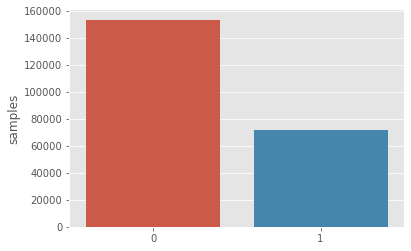

In [5]:
x = df.target.value_counts()
sns.barplot(x.index, x)
plt.gca().set_ylabel('samples')

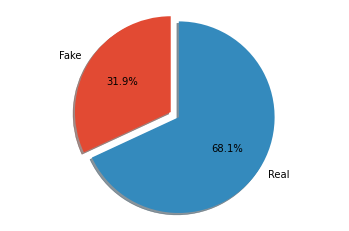

In [6]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Fake', 'Real'
sizes = [x[1], x[0]]
explode = (0, 0.1)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

## Exploratory Data Analysis

### Number of characters in tweets

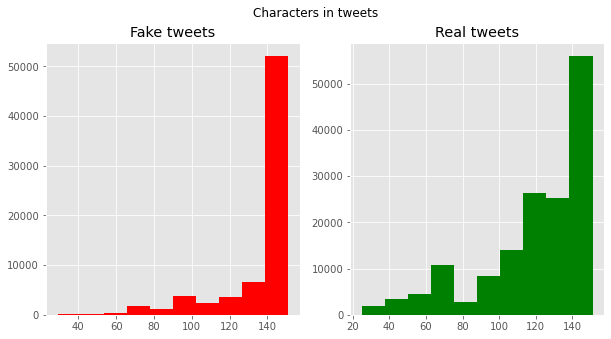

In [7]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=df[df['target']==1]['text'].str.len()
ax1.hist(tweet_len,color='red')
ax1.set_title('Fake tweets')

tweet_len=df[df['target']==0]['text'].str.len()
ax2.hist(tweet_len,color='green')
ax2.set_title('Real tweets')

fig.suptitle('Characters in tweets')
plt.show()

### Number of words in a tweet

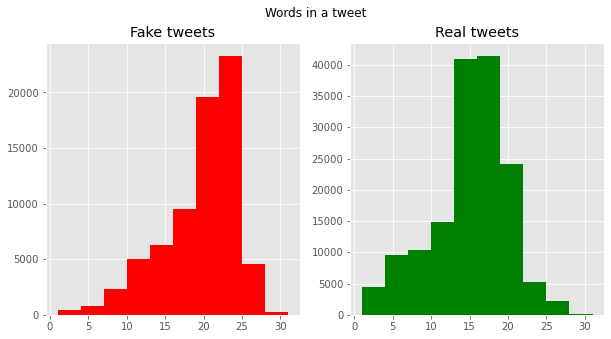

In [8]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=df[df['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len,color='red')
ax1.set_title('Fake tweets')

tweet_len=df[df['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='green')
ax2.set_title('Real tweets')

fig.suptitle('Words in a tweet')
plt.show()

###  Average word length in a tweet

D:\anaconda\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\anaconda\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0.98, 'Average word length in each tweet')

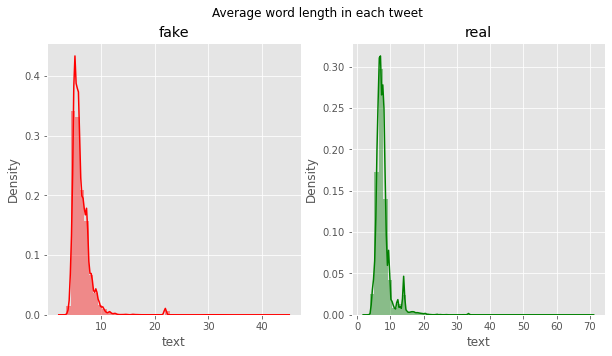

In [9]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
word=df[df['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('fake')

word=df[df['target']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('real')

fig.suptitle('Average word length in each tweet')

In [10]:
def create_corpus(target):
    corpus=[]
    
    for x in df[df['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

### Common stopwords in tweets

Stop words in fake tweets:

In [11]:
corpus=create_corpus(0)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 


<BarContainer object of 10 artists>

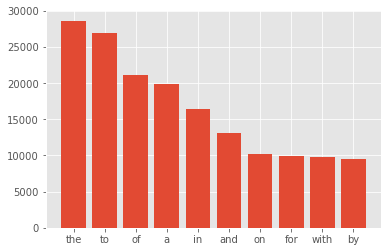

In [12]:
x,y=zip(*top)
plt.bar(x,y)

Stop words in real tweets:

<BarContainer object of 10 artists>

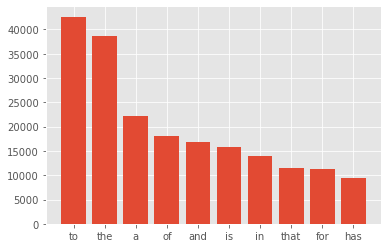

In [13]:
corpus=create_corpus(1)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
    


x,y=zip(*top)
plt.bar(x,y)

### Analyzing punctuations

Punctuations in real tweets:

<BarContainer object of 22 artists>

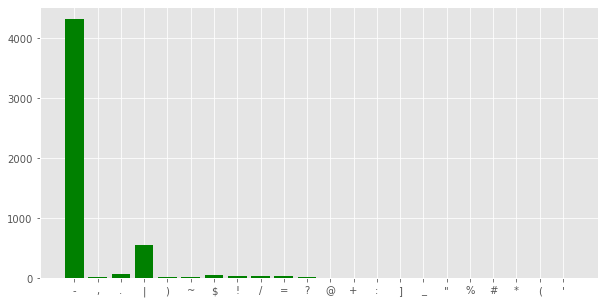

In [14]:
plt.figure(figsize=(10,5))
corpus=create_corpus(1)

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y,color='green')

Punctuations in fake tweets:

<BarContainer object of 22 artists>

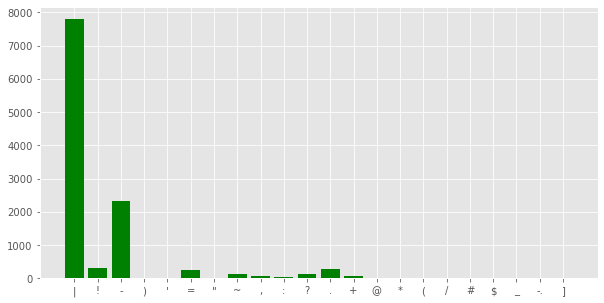

In [15]:
plt.figure(figsize=(10,5))
corpus=create_corpus(0)

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y,color='green')

In cleaning section, we'll remove these punctuations.

### Common words ?

In [16]:
counter=Counter(corpus)
most=counter.most_common()
x=[]
y=[]
for word,count in most[:40]:
    if (word not in stop) :
        x.append(word)
        y.append(count)

<AxesSubplot:>

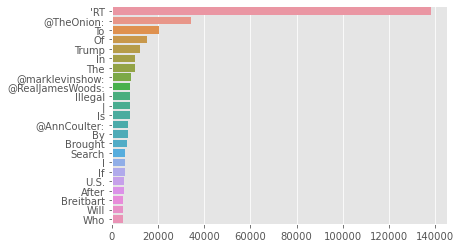

In [17]:
sns.barplot(x=y,y=x)

### Bigram analysis

The most common bigrams in tweets:

In [18]:
def get_top_tweet_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

<AxesSubplot:>

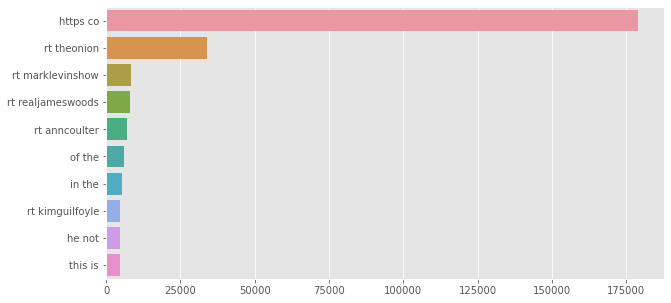

In [19]:
plt.figure(figsize=(10,5))
top_tweet_bigrams=get_top_tweet_bigrams(df['text'], 10)
x,y=map(list,zip(*top_tweet_bigrams))
sns.barplot(x=y,y=x)

Our model won't understand the meaning of 'rt' or 'https', so we are going to remove them in cleaning section.

add features column

In [20]:
#Extracting mention tags
def mention_count(tweet):
    words = tweet.split()
    mentions = [word for word in words if word.startswith('@')]
    return len(mentions)

df['mention_count'] = df['text'].apply(mention_count)

## Data Cleaning

In this section we do the required cleaning of tweets' text. With the cleaned text we are going to have a better model.

### Removing urls

In [21]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

In [22]:
df['text']=df['text'].apply(lambda x : remove_URL(x))

### Removing "RT @x: "

In [23]:
def remove_RT(text):
    return re.sub('(RT @.*: )', '', text)

In [24]:
df['text']=df['text'].apply(lambda x : remove_RT(x))

### Romoving Emojis

In [25]:
# Reference : https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [26]:
df['text']=df['text'].apply(lambda x: remove_emoji(x))

### Removing punctuations

In [27]:
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

In [28]:
df['text']=df['text'].apply(lambda x : remove_punct(x))

### Removing "…"

In [29]:
def remove_3dots(text):
    text = text.replace("...", " etc ").strip()
    return text.replace("…", " etc ").strip()

In [30]:
df['text']=df['text'].apply(lambda x : remove_3dots(x))

In [31]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to C:\Users\BARAN
[nltk_data]     JOON\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Add Features column

In [32]:
df['char_count'] = df['text'].apply(len) #Extracting all characters long
#Extracting sentence length(number of words)
stop = stopwords.words('english')

def words_only_count(tweet):
    words = tweet.split()
    words_only = [word for word in words if word not in stop and
              not word.startswith(('#', '@'))]
    return len(words_only)

df['words_only_count'] = df['text'].apply(words_only_count)

import textstat
import re

df['flesch_readability_grade']=df['text'].apply(textstat.flesch_reading_ease)

## GloVe for Vectorization

Here we will use GloVe pretrained corpus model to represent our words. It is available in 3 varieties :50D ,100D and 200 Dimentional.We will try 100 D here.

In [33]:
def create_corpus(df):
    corpus=[]
    for tweet in tqdm(df['text']):
        words=[word.lower() for word in word_tokenize(tweet) if((word.isalpha()==1) & (word not in stop))]
        corpus.append(words)
    return corpus

In [34]:
corpus=create_corpus(df)

100%|████████████████████████████████| 225405/225405 [02:49<00:00, 1328.18it/s]


In [35]:
embedding_dict={}
with open('glove.6B.100d.txt','r', encoding="utf8") as f:
    for line in f:
        values=line.split()
        word=values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors
f.close()

We created a embedding_dict that is a dictionary of all words and their vectors in GloVe.
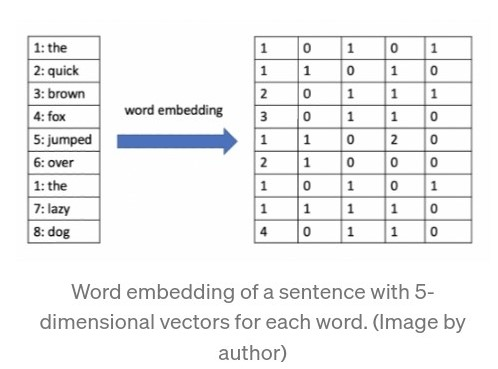

In [36]:
print("Example of vector of 'the': ", embedding_dict['the'])

Example of vector of 'the':  [-0.038194 -0.24487   0.72812  -0.39961   0.083172  0.043953 -0.39141
  0.3344   -0.57545   0.087459  0.28787  -0.06731   0.30906  -0.26384
 -0.13231  -0.20757   0.33395  -0.33848  -0.31743  -0.48336   0.1464
 -0.37304   0.34577   0.052041  0.44946  -0.46971   0.02628  -0.54155
 -0.15518  -0.14107  -0.039722  0.28277   0.14393   0.23464  -0.31021
  0.086173  0.20397   0.52624   0.17164  -0.082378 -0.71787  -0.41531
  0.20335  -0.12763   0.41367   0.55187   0.57908  -0.33477  -0.36559
 -0.54857  -0.062892  0.26584   0.30205   0.99775  -0.80481  -3.0243
  0.01254  -0.36942   2.2167    0.72201  -0.24978   0.92136   0.034514
  0.46745   1.1079   -0.19358  -0.074575  0.23353  -0.052062 -0.22044
  0.057162 -0.15806  -0.30798  -0.41625   0.37972   0.15006  -0.53212
 -0.2055   -1.2526    0.071624  0.70565   0.49744  -0.42063   0.26148
 -1.538    -0.30223  -0.073438 -0.28312   0.37104  -0.25217   0.016215
 -0.017099 -0.38984   0.87424  -0.72569  -0.51058  -0.52028  

As we saw in EDA step, we don't have more than 35 words in every tweet(after removed stop words), so we assign an array for every tweet and for each word of tweet we have a 100D matrix. Then we do padding and truncating to add them to the sequences of words.

In [37]:
MAX_LEN=35
tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(corpus)
sequences=tokenizer_obj.texts_to_sequences(corpus)

tweet_pad=pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')

We tokenized all of the words in corpus, so we have a token (an integer) to point to each word. In tweet_pad we have a new dataset of tweets with fix sizes of tokens (not actual words).

In [38]:
print("Example of a sentence in tweet_pad:", tweet_pad[0])
print("What it realy was:", df['text'][0])

Example of a sentence in tweet_pad: [   4 1064 1184  251 1311 1381 1394  654  188  389   13    8  568    1
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0]
What it realy was: The Endangered Species Act saved the bald eagle and was signed into law by a Republican president This has nothing to etc


In [39]:
word_index=tokenizer_obj.word_index
print('Number of unique words:',len(word_index))

Number of unique words: 26072


Based on our tokenizing and each words token, we are going to build a embedding_matrix which points to the relating embedding of each word. For example 'the''s token is 4, and forth elemnt of embedding_matrix has a 100D array of 'the' embedding value.

In [40]:
num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,100))

for word,i in tqdm(word_index.items()):
    if i > num_words:
        continue
    
    emb_vec=embedding_dict.get(word)
    if emb_vec is not None:
        embedding_matrix[i]=emb_vec

100%|████████████████████████████████| 26072/26072 [00:00<00:00, 111814.60it/s]


## Model

In [41]:
model=Sequential()#add layers in a sequence

embedding=Embedding(num_words,100,embeddings_initializer=Constant(embedding_matrix),
                   input_length=MAX_LEN,trainable=False)

model.add(embedding)#first layer:word embeding
model.add(SpatialDropout1D(0.2))#second layer:drop out for avoid overfitting
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))#third layer:Last short time memory model with 64 neurons(memory units)
model.add(Dense(1, activation='sigmoid'))#fourth layer:activation function=sigmoid for binary classification


optimzer=Adam(learning_rate=1e-4)

model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy'])

In [42]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 35, 100)           2607300   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 35, 100)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                42240     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 2,649,605
Trainable params: 42,305
Non-trainable params: 2,607,300
_________________________________________________________________


In [43]:
X_train,X_test,y_train,y_test=train_test_split(tweet_pad,df['target'].values,test_size=0.4)
X_valid,X_test,y_valid,y_test=train_test_split(X_test,y_test,test_size=0.5)
print('Shape of Train',X_train.shape)
print("Shape of Test ",X_test.shape)
print("Shape of Validation ",X_valid.shape)

Shape of Train (135243, 35)
Shape of Test  (45081, 35)
Shape of Validation  (45081, 35)


## Training

In [44]:
history=model.fit(X_train,y_train,batch_size=32,epochs=20,validation_data=(X_valid, y_valid),verbose=2)

Epoch 1/20
4227/4227 - 203s - loss: 0.2896 - accuracy: 0.8855 - val_loss: 0.1705 - val_accuracy: 0.9380
Epoch 2/20
4227/4227 - 175s - loss: 0.1931 - accuracy: 0.9290 - val_loss: 0.1344 - val_accuracy: 0.9562
Epoch 3/20
4227/4227 - 177s - loss: 0.1686 - accuracy: 0.9394 - val_loss: 0.1168 - val_accuracy: 0.9594
Epoch 4/20
4227/4227 - 175s - loss: 0.1530 - accuracy: 0.9455 - val_loss: 0.1074 - val_accuracy: 0.9631
Epoch 5/20
4227/4227 - 176s - loss: 0.1419 - accuracy: 0.9489 - val_loss: 0.1024 - val_accuracy: 0.9658
Epoch 6/20
4227/4227 - 183s - loss: 0.1336 - accuracy: 0.9523 - val_loss: 0.0968 - val_accuracy: 0.9663
Epoch 7/20
4227/4227 - 192s - loss: 0.1250 - accuracy: 0.9555 - val_loss: 0.0903 - val_accuracy: 0.9692
Epoch 8/20
4227/4227 - 193s - loss: 0.1210 - accuracy: 0.9563 - val_loss: 0.0874 - val_accuracy: 0.9698
Epoch 9/20
4227/4227 - 186s - loss: 0.1152 - accuracy: 0.9592 - val_loss: 0.0847 - val_accuracy: 0.9706
Epoch 10/20
4227/4227 - 183s - loss: 0.1111 - accuracy: 0.9603 -

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


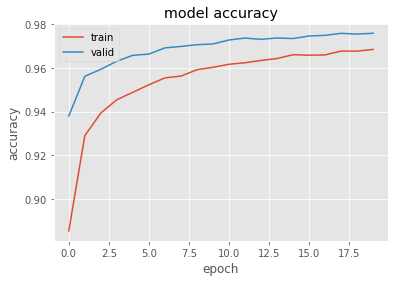

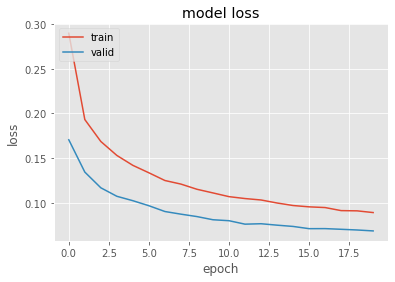

In [45]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

## Evaluation

In [46]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=32)
print("test loss, test acc:", results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 3 samples")
predictions = model.predict(X_test[:3])
print("predictions shape:", predictions.shape)

Evaluate on test data
1409/1409 [==============================] - 14s 10ms/step - loss: 0.0690 - accuracy: 0.9764
test loss, test acc: [0.06904523819684982, 0.9764423966407776]
Generate predictions for 3 samples
predictions shape: (3, 1)


In [47]:
print("Example of prediction for three samples: " , predictions)

Example of prediction for three samples:  [[9.9945050e-01]
 [1.3299584e-03]
 [7.8517199e-04]]


In [48]:
y_pred = model.predict(X_test)

In [49]:
df['model_output']=model.predict(tweet_pad)
df.head()

,tweet_id,text,target,mention_count,char_count,words_only_count,flesch_readability_grade,model_output
0,1161040537207463936,The Endangered Species Act saved the bald eagl...,1,1,121,14,57.61,0.999166
1,1176360756239118342,Interesting concept impeach first find facts ...,1,1,115,17,44.75,0.999144
2,1099036648573145088,BuildTheWall DeportThemAll,0,1,26,2,-49.00,0.091140
3,1092915693203480577,Why would the MEXICAN GOV’T fund this Who are ...,0,1,66,7,83.66,0.002761
4,1149038450668187654,Sweden Announces Plan To Get 100 Of Energy Fro...,0,1,88,16,63.70,0.000236


In [50]:
df.to_csv('df_MinaDF.csv')

In [51]:
y_pred_binary = []
for x in y_pred:
    if x > 0.5:
        x = 1
    else:
        x = 0
    y_pred_binary.append(x)

<AxesSubplot:>

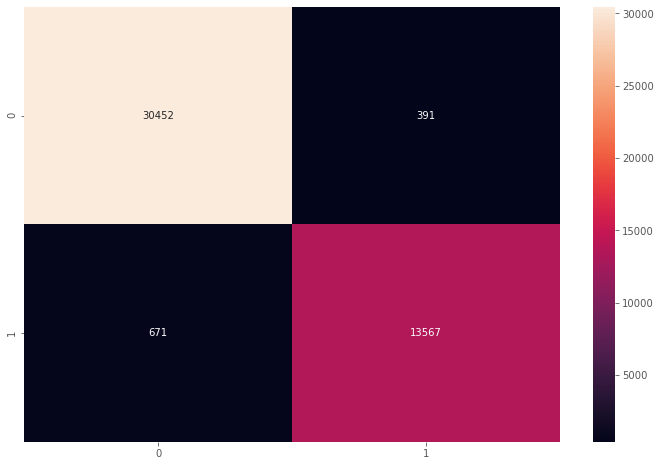

In [52]:
fig, ax = plt.subplots(figsize=(12,8))

confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred_binary))

sns.heatmap(confusion_matrix_df, annot=True, fmt="d")

In [53]:
print("confusion matrix without graphics: ", confusion_matrix(y_test, y_pred_binary))

confusion matrix without graphics:  [[30452   391]
 [  671 13567]]


In [54]:
print(classification_report(y_test, y_pred_binary, target_names = ['real', 'fake']))

              precision    recall  f1-score   support

        real       0.98      0.99      0.98     30843
        fake       0.97      0.95      0.96     14238

    accuracy                           0.98     45081
   macro avg       0.98      0.97      0.97     45081
weighted avg       0.98      0.98      0.98     45081



Precision = true positives / (true positives + false positives) = fake tweets correctly identified / (fake tweets correctly identified + real tweets incorrectly labeled as fake tweets)<br>
Recall = true positives / (true positives + false negatives) = fake tweets correctly identified / (fake tweets correctly identified + fake tweets incorrectly identified)<br>
The F1 score is the harmonic mean of precision and recall taking both metrics into account. We use the harmonic mean instead of a simple average because it punishes extreme values. A classifier with a precision of 1.0 and a recall of 0.0 has a simple average of 0.5 but an F1 score of 0. The F1 score gives equal weight to both measures



References:
Goodfellow. I., Bengio. Y., Courville. A, Deep learning addaptive computation and machine learning.

https://matplotlib.org/3.1.1/gallery/pie_and_polar_charts/pie_features.html

https://keras.io/layers/merging_layers

https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

https://www.tensorflow.org/guide/keras/train_and_evaluate
